## Preprocessing datasets

In [4]:
#Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import time


In [5]:
# Paths to datasets
file_path1 = '../data/Crime_Data_from_2010_to_2019.csv'
file_path2 = '../data/Crime_Data_from_2020_to_Present.csv'


In [6]:
# Define the chunk size
chunk_size = 10000

# Start the timer
start_time = time.time()

# Read and concatenate both CSV files into a single DataFrame
df = pd.concat([
    chunk for chunk in pd.read_csv(file_path1, chunksize=chunk_size)
] + [
    chunk for chunk in pd.read_csv(file_path2, chunksize=chunk_size)
], ignore_index=True)

# End the timer
end_time = time.time()

# Calculate the execution time
execution_time = end_time - start_time

# Print the first few rows of the DataFrame
print(df.head(1))

# Print the execution time
print("Execution Time using chunks:", execution_time, "seconds")

     DR_NO               Date Rptd                DATE OCC  TIME OCC  AREA   \
0  1307355  02/20/2010 12:00:00 AM  02/20/2010 12:00:00 AM      1350   13.0   

  AREA NAME  Rpt Dist No  Part 1-2  Crm Cd               Crm Cd Desc  ...  \
0    Newton         1385         2     900  VIOLATION OF COURT ORDER  ...   

    Status Desc  Crm Cd 1 Crm Cd 2 Crm Cd 3  Crm Cd 4  \
0  Adult Arrest     900.0      NaN      NaN       NaN   

                                 LOCATION  Cross Street      LAT       LON  \
0  300 E  GAGE                         AV           NaN  33.9825 -118.2695   

  AREA  
0  NaN  

[1 rows x 29 columns]
Execution Time using chunks: 10.090022087097168 seconds


In [7]:
# Dropping unnecessary features
## The AREA feature has to be two times due to encoding errors of the dataset producer
df.drop(['DR_NO', 'Date Rptd', 'AREA','AREA ', 'Rpt Dist No', 'Weapon Used Cd', 'Mocodes', 'Status', 'Part 1-2', 'Premis Cd', 'Crm Cd 3', 'Crm Cd 4', 'Cross Street'] , axis=1, inplace=True)


In [8]:
from datetime import time
# Function to convert integer (times) to datetime
def int_to_time(integer):
    # Assuming integer represents time in HHMM format
    hour = integer // 100
    minute = integer % 100
    return time(hour, minute)

In [9]:
# Creating columns to represent the date of a crime and the time of a crime
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p')
df['TIME OCC'] = df['TIME OCC'].apply(int_to_time)

In [10]:
# Combining date and time into a singular datetime column
df['DATETIME OCC'] = df['DATE OCC'] + pd.to_timedelta(df['TIME OCC'].astype(str))

# Using the datetime as the index
df.set_index('DATETIME OCC', inplace = True)

#### Keep relevant/frequent crimes in the last 15 years.
**Step 1:** <br>
To do this, we first ensure that the data is encoded correctly. We can do this by relating the description of crime codes to the crime codes themselves. <br>
(note: Crime Cd is used as it should encode the most important crime, so Crime cd =/= Crm Cd 1 in every instance)

**Step 2:** <br>
Manually check how often the Xth crime occurs to gauge frequency. <br>
Determine a threshold for how frequent a crime has to have occurred in the last 15 years for it to be relevant (>1% of the time).

**Step 3:** <br>
Filter the dataset to remove any crime that did not occur frequently.

In [11]:
# Step 1:
# Count the amount of times certain crimes have happened over the last 15 years
# Make sure the both fields have the same value to ensure data integrity

# Get the frequency of crime descriptions
crime_code_desc_freq = df['Crm Cd Desc'].value_counts()

# Get the frequency of crime codes
crime_code_freq = df['Crm Cd'].value_counts()

# Initialize a flag to indicate if at least one count does not match
count_match_flag = True

# Iterate over each unique crime description
for desc, desc_count in crime_code_desc_freq.items():
    # Get the count of the corresponding crime code
    code_count = crime_code_freq[df[df['Crm Cd Desc'] == desc]['Crm Cd'].iloc[0]]
    
    # Check if the counts match
    if desc_count != code_count:
        count_match_flag = False
        print(f"Counts for '{desc}' do not match: {desc_count} (desc) vs {code_count} (code)")

# Check if any counts did not match and print the result
if count_match_flag:
    print("Counts match for all crime descriptions.")
else:
    print("At least one count does not match for a crime description.")


Counts match for all crime descriptions.


In [12]:
# Step 2:
# Manually check how frequent the 30th most frequent crime occurs
print(f'Amount of occurences of the crime {crime_code_desc_freq.index[30]}: {crime_code_desc_freq.iloc[30]}')


Amount of occurences of the crime RAPE, FORCIBLE: 14447


In [13]:
# Determine a threshold for frequency
#  Calculate Total Occurrences of the Most Common Crime
total_occurrences_most_common = crime_code_desc_freq.iloc[0]

# Calculate 5% Threshold
one_percent_threshold = total_occurrences_most_common * 0.05

# Create an empty Series to store significant crimes
significant_crimes = pd.Series(dtype=int)

# Identify Significant Frequencies
for crime_type, occurrences in crime_code_desc_freq.items():
    if occurrences >= one_percent_threshold:
        # Add the crime type and its count to the significant crimes Series
        significant_crimes[crime_type] = occurrences

# Display the Series containing significant crimes
print(significant_crimes)
print(len(significant_crimes))

BATTERY - SIMPLE ASSAULT                                    262949
VEHICLE - STOLEN                                            257653
BURGLARY FROM VEHICLE                                       218328
BURGLARY                                                    203627
THEFT PLAIN - PETTY ($950 & UNDER)                          196372
THEFT OF IDENTITY                                           186319
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)     164706
INTIMATE PARTNER - SIMPLE ASSAULT                           159938
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT              144527
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)             123566
ROBBERY                                                     114986
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                    114098
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD    105037
CRIMINAL THREATS - NO WEAPON DISPLAYED                       75337
SHOPLIFTING - PETTY THEFT ($950 & UNDER)                     7

In [14]:
# Extract the crime descriptions from the index of the significant crimes Series
significant_crime_descriptions = significant_crimes.index

# Filter the DataFrame based on crime descriptions
filtered_df = df[df['Crm Cd Desc'].isin(significant_crime_descriptions)]

# Display the head of the filtered DataFrame
print(filtered_df.head(1))


                      DATE OCC  TIME OCC AREA NAME  Crm Cd  \
DATETIME OCC                                                 
2010-02-20 13:50:00 2010-02-20  13:50:00    Newton     900   

                                  Crm Cd Desc  Vict Age Vict Sex Vict Descent  \
DATETIME OCC                                                                    
2010-02-20 13:50:00  VIOLATION OF COURT ORDER        48        M            H   

                                Premis Desc Weapon Desc   Status Desc  \
DATETIME OCC                                                            
2010-02-20 13:50:00  SINGLE FAMILY DWELLING         NaN  Adult Arrest   

                     Crm Cd 1  Crm Cd 2  \
DATETIME OCC                              
2010-02-20 13:50:00     900.0       NaN   

                                                   LOCATION      LAT       LON  
DATETIME OCC                                                                    
2010-02-20 13:50:00  300 E  GAGE                         

In [15]:
# Sorting the dataframe by date
df_sorted = filtered_df.sort_index()

# Observe a sample of the dataframe
df_sorted.head(1)

,DATE OCC,TIME OCC,AREA NAME,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Desc,Weapon Desc,Status Desc,Crm Cd 1,Crm Cd 2,LOCATION,LAT,LON
DATETIME OCC,,,,,,,,,,,,,,,,
2010-01-01 00:01:00,2010-01-01,00:01:00,Harbor,354,THEFT OF IDENTITY,21,F,H,SINGLE FAMILY DWELLING,NaN,Invest Cont,354.0,NaN,700 WILMINGTON BL,33.7779,-118.274


In [16]:
# Saving the combined & filtered & sorted dataframe to a new csv
# df_sorted.to_csv('../data/Crime_Data_20_Year_Analysis.csv')

## Exploring the data

### Temporal Analysis <br>
**Monthly trends**

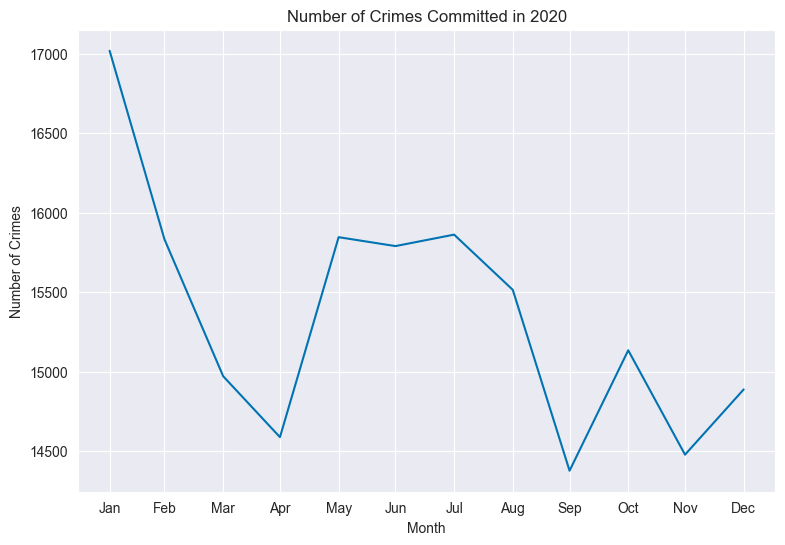

In [17]:
# Filter data for the year 2020
df_2020 = df_sorted[df_sorted['DATE OCC'].dt.year == 2020]

# Group by month and count occurrences
monthly_counts = df_2020.groupby(pd.Grouper(key='DATE OCC', freq='ME')).size()

# Reset index to access month as a column
monthly_counts = monthly_counts.reset_index()

# Rename columns
monthly_counts.columns = ['Month', 'Number of Crimes']

# Set the style and palette
sns.set_style("darkgrid")  # Change the style to darkgrid
sns.set_palette("colorblind")  # Change the color palette

# Plot the line chart using Seaborn
plt.figure(figsize=(9, 6))
sns.lineplot(data=monthly_counts, x='Month', y='Number of Crimes')

# Set titles, labels, and other plot properties
plt.title('Number of Crimes Committed in 2020')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.xticks(monthly_counts['Month'], [month.strftime('%b') for month in monthly_counts['Month']])
plt.show()

**Daily Trends**

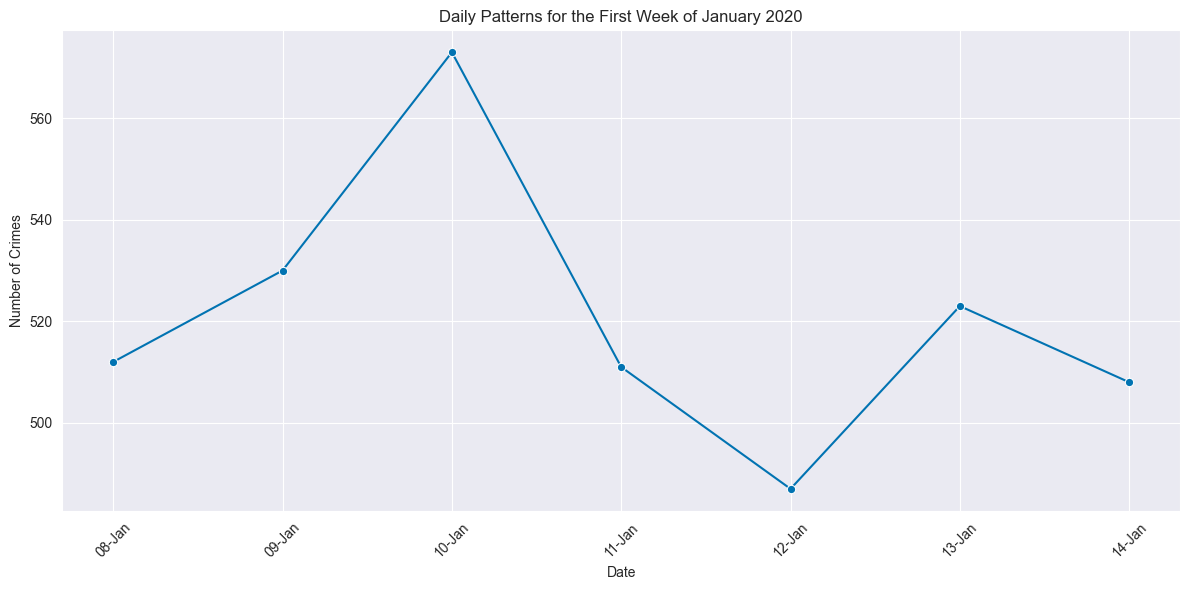

In [18]:
import matplotlib.dates as mdates

# Filter data for January 2020
start_date = '2020-01-08'
end_date = '2020-01-14'
df_january = df_sorted[(df_sorted['DATE OCC'] >= start_date) & (df_sorted['DATE OCC'] <= end_date)]

# Group by day and count occurrences
daily_counts_january = df_january.groupby(pd.Grouper(key='DATE OCC', freq='D')).size()

# Reset index to access day as a column
daily_counts_january = daily_counts_january.reset_index()

# Rename columns
daily_counts_january.columns = ['Date', 'Number of Crimes']

# Set the style and palette
sns.set_style("darkgrid")  # Change the style to darkgrid
sns.set_palette("colorblind")  # Change the color palette

# Plot the line chart using Seaborn
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
sns.lineplot(data=daily_counts_january, x='Date', y='Number of Crimes', marker='o')

# Set titles, labels, and other plot properties
plt.title('Daily Patterns for the First Week of January 2020')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)

# Format x-axis dates to show only day and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [19]:
df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2814296 entries, 2010-01-01 00:01:00 to 2024-03-04 21:40:00
Data columns (total 16 columns):
 #   Column        Dtype         
---  ------        -----         
 0   DATE OCC      datetime64[ns]
 1   TIME OCC      object        
 2   AREA NAME     object        
 3   Crm Cd        int64         
 4   Crm Cd Desc   object        
 5   Vict Age      int64         
 6   Vict Sex      object        
 7   Vict Descent  object        
 8   Premis Desc   object        
 9   Weapon Desc   object        
 10  Status Desc   object        
 11  Crm Cd 1      float64       
 12  Crm Cd 2      float64       
 13  LOCATION      object        
 14  LAT           float64       
 15  LON           float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(9)
memory usage: 365.0+ MB


C:\Users\neere\AppData\Local\Temp\ipykernel_1912\2330191635.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_specific_day['Hour'] = df_specific_day['TIME OCC'].apply(lambda x: x.hour)


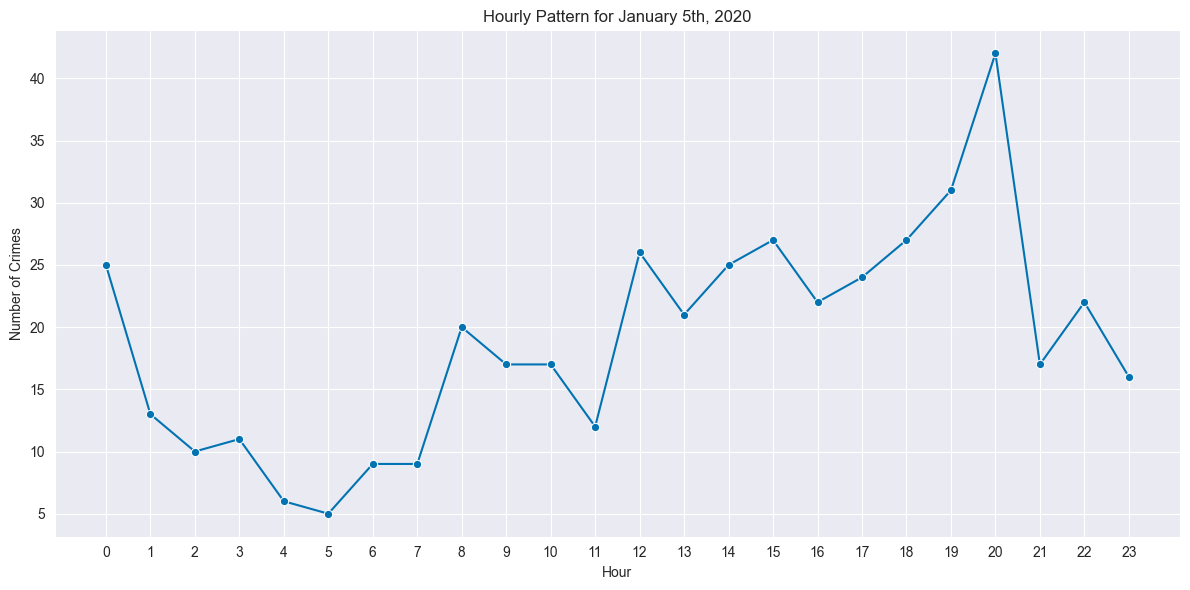

In [20]:
# Assuming 'TIME OCC' is a datetime column combining hour and minute information
# Filter data for a specific day in January 2020
target_date = '2020-01-05'
df_specific_day = df_sorted[df_sorted['DATE OCC'].dt.date == pd.to_datetime(target_date).date()]

# Extract hour from 'TIME OCC' column
df_specific_day['Hour'] = df_specific_day['TIME OCC'].apply(lambda x: x.hour)

# Group by hour and count occurrences
hourly_counts_specific_day = df_specific_day.groupby('Hour').size()

# Reset index to access hour as a column
hourly_counts_specific_day = hourly_counts_specific_day.reset_index()

# Rename columns
hourly_counts_specific_day.columns = ['Hour', 'Number of Crimes']

# Set the style and palette
sns.set_style("darkgrid")  # Change the style to darkgrid
sns.set_palette("colorblind")  # Change the color palette

# Plot the line chart using Seaborn
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
sns.lineplot(data=hourly_counts_specific_day, x='Hour', y='Number of Crimes', marker='o')

# Set titles, labels, and other plot properties
plt.title('Hourly Pattern for January 5th, 2020')
plt.xlabel('Hour')
plt.ylabel('Number of Crimes')
plt.xticks(range(24))  # Set ticks for all 24 hours
plt.grid(True)

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


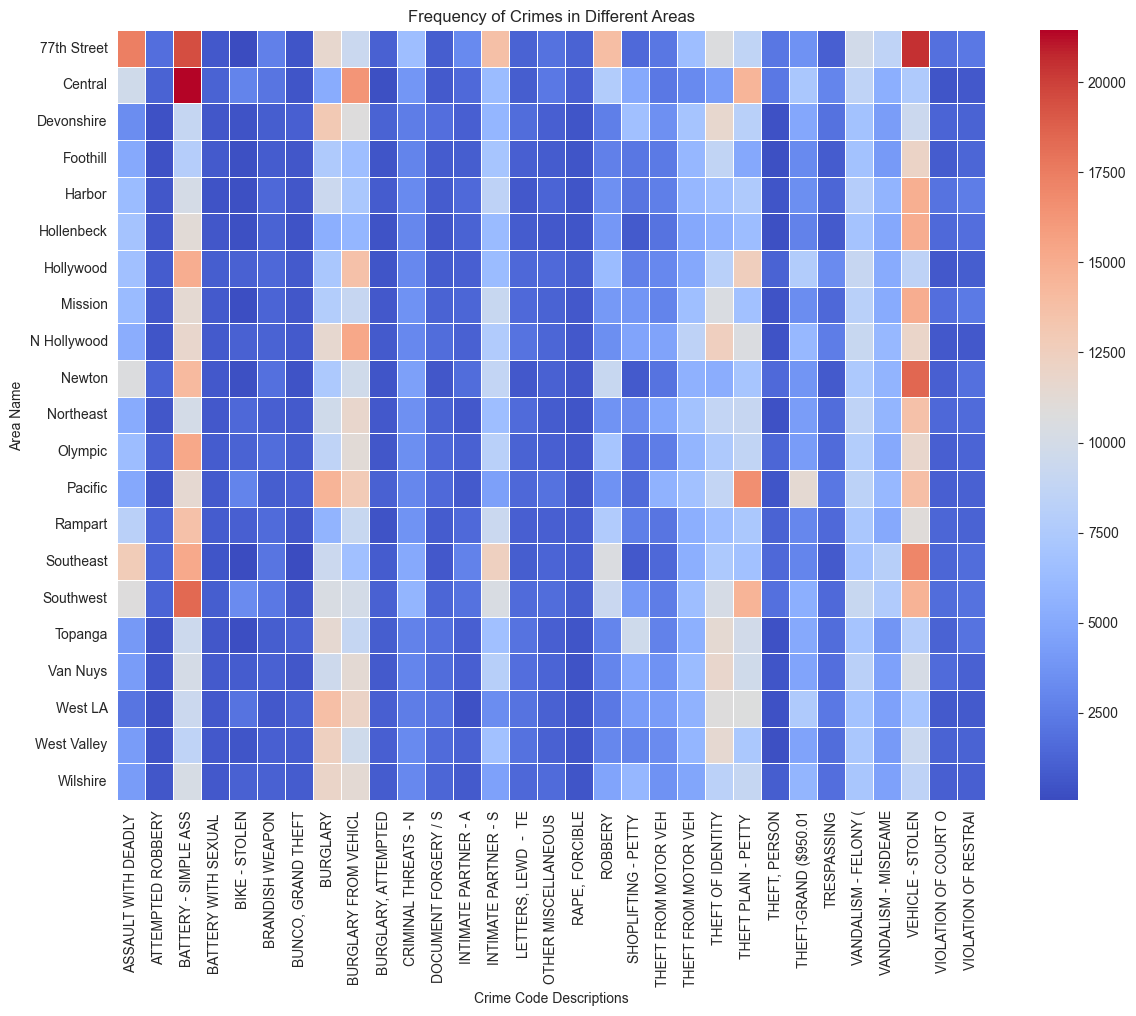

In [21]:
# Pivot the DataFrame to get counts of each crime in each area
pivot_df = df_sorted.pivot_table(index='AREA NAME', columns='Crm Cd Desc', aggfunc='size', fill_value=0)

# Truncate the length of crime code descriptions for readability
max_length = 20 
pivot_df.columns = [col[:max_length] for col in pivot_df.columns]

# Create the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_df, cmap='coolwarm', linewidths=.5)
plt.title('Frequency of Crimes in Different Areas')
plt.xlabel('Crime Code Descriptions')
plt.ylabel('Area Name')
plt.show()


In [34]:
geojson_path= '../data/los-angeles.geojson'

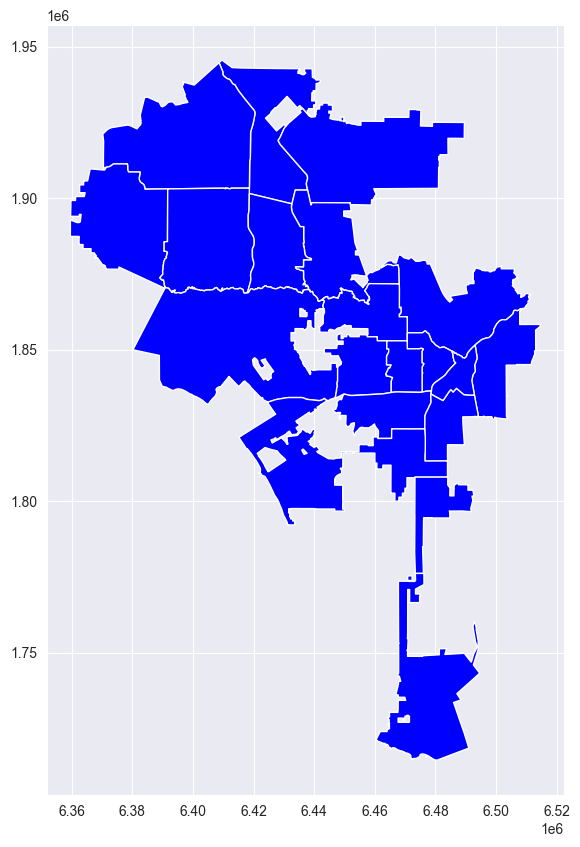

In [49]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the GeoJSON file
gdf = gpd.read_file(geojson_path)

# Plot all districts with the same color
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='blue')  # Change 'blue' to any color you prefer
plt.show()
